## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file.

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [1]:
import pandas as pd 
from skimage.io import imread
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import os 

def load_imgs_and_keypoints(dirname='./data'):
    images = []
    points = pd.read_csv(dirname + '/gt.csv')
    del points["filename"]
    
    for i in range(len(os.listdir('./data/images'))):
        img = imread(os.path.join(dirname + '/images', str(i).zfill(5) + '.jpg'))
        
        if len(img.shape) != 3:
            img = gray2rgb(img)
        
        # [-0.5;0.5] range로 scaling
        for j in range(points.shape[1]):
            if j % 2 != 0:
                points.iloc[i,j] = (points.iloc[i,j] / img.shape[1]) - 0.5
            else :
                points.iloc[i,j] = (points.iloc[i,j] / img.shape[0]) - 0.5
        
        img = resize(img, (100, 100), anti_aliasing=True) # 모든 이미지 사이즈를 100x100으로 맞춰줌
        
        if img is not None:
            images.append(img)
    
    return images, array(points)

imgs, points = load_imgs_and_keypoints()

array([-0.30534351, -0.30534351, -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480916, -0.30152672, -0.24045802, -0.20610687,
       -0.17557252, -0.21374046, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267176, -0.19847328,  0.23664122, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412214,  0.03435115,
        0.1870229 ,  0.14122137,  0.18320611])

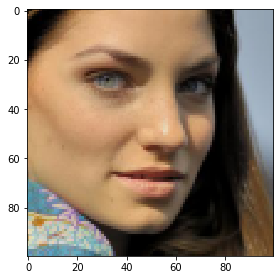

In [2]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

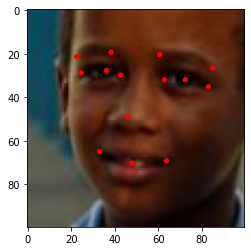

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def visualize_points(img, points):
    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')

    # Show the image
    ax.imshow(img)

    for i in range(int(len(points)/2)):
        circ = Circle( ( (points[i*2] + 0.5) * 100, (points[(i*2 + 1)] + 0.5) * 100 ) ,1, color="red")

        ax.add_patch(circ)

        # Show the image
    plt.show()
    
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [4]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

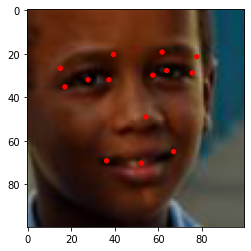

In [5]:
def flip_img(img, points):
    
    # 사진 중에 3 channel이 아닌 grayscale 사진이 존재함
    if len(img.shape) != 3:
        f_img = img[:,::-1]
    else:
        f_img = img[:,::-1,:]
    
    f_points = zeros(int(points.shape[0]))
    reverse_points = points[::-1]
    for i in range(int(points.shape[0]/2)):
        f_points[i*2] = - reverse_points[i*2 + 1] # 음수 부호: X축 기준으로 좌우 반전 해주어야하기 때문
        f_points[i*2 + 1] = reverse_points[i*2]

    return f_img, f_points

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [6]:
aug_imgs_train = []
aug_points_train = []

for i in range(len(imgs_train)):
    aug_imgs_train.append(imgs_train[i])
    aug_points_train.append(points_train[i])
    
    f_img, f_points = flip_img(imgs_train[i], points_train[i])
    
    aug_imgs_train.append(f_img)
    aug_points_train.append(f_points)

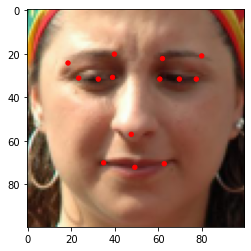

In [7]:
visualize_points(aug_imgs_train[4], aug_points_train[4])

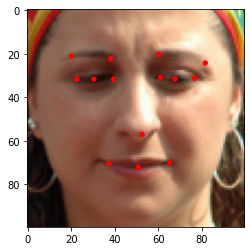

In [8]:
visualize_points(aug_imgs_train[5], aug_points_train[5])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [9]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(28, activation='softmax'))

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)        

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [10]:
import numpy as np
aug_imgs_train_reshape = np.concatenate([img[np.newaxis] for img in aug_imgs_train])
aug_imgs_train_reshape.shape

(10800, 100, 100, 3)

In [11]:
aug_points_train_reshape = np.concatenate([point[np.newaxis] for point in aug_points_train])
aug_points_train_reshape.shape

(10800, 28)

In [12]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

model.compile(loss='mse',
              optimizer=Adam(lr=0.001),
              metrics=['mse'])

model.fit(aug_imgs_train_reshape, aug_points_train_reshape, epochs=10, batch_size=64)

Epoch 1/10
10800/10800 [==============================] - 131s 12ms/step - loss: 0.0351 - mse: 0.0351
Epoch 2/10
10800/10800 [==============================] - 133s 12ms/step - loss: 0.0343 - mse: 0.0343
Epoch 3/10
10800/10800 [==============================] - 127s 12ms/step - loss: 0.0343 - mse: 0.0343
Epoch 4/10
10800/10800 [==============================] - 119s 11ms/step - loss: 0.0343 - mse: 0.0343
Epoch 5/10
10800/10800 [==============================] - 121s 11ms/step - loss: 0.0343 - mse: 0.0343
Epoch 6/10
10800/10800 [==============================] - 122s 11ms/step - loss: 0.0343 - mse: 0.0343
Epoch 7/10
10800/10800 [==============================] - 122s 11ms/step - loss: 0.0343 - mse: 0.0343
Epoch 8/10
10800/10800 [==============================] - 121s 11ms/step - loss: 0.0342 - mse: 0.0342
Epoch 9/10
10800/10800 [==============================] - 118s 11ms/step - loss: 0.0342 - mse: 0.0342
Epoch 10/10
10800/10800 [==============================] - 115s 11ms/step - loss: 

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [13]:
imgs_val_reshape = np.concatenate([img[np.newaxis] for img in imgs_val])
imgs_val_reshape.shape

(600, 100, 100, 3)

In [14]:
points_val_reshape = np.concatenate([point[np.newaxis] for point in points_val])
points_val_reshape.shape

(600, 28)

In [15]:
# Model evaluation score
val_loss, val_acc = model.evaluate(imgs_val_reshape, points_val_reshape)
print(val_acc)

600/600 [==============================] - 2s 3ms/step
0.03437136486172676


In [16]:
pred = model.predict(imgs_val_reshape)

In [17]:
pred[1]

array([2.3263636e-05, 4.7659058e-05, 2.0826141e-05, 5.7240090e-05,
       1.0796950e-01, 4.2143569e-05, 1.4561301e-01, 2.5206507e-05,
       1.6740803e-05, 2.2875900e-05, 2.0399093e-05, 2.0895433e-05,
       1.8998857e-05, 1.6792226e-05, 9.8890454e-02, 1.8045159e-05,
       1.6157067e-01, 1.7288430e-05, 2.2982088e-01, 2.2977001e-05,
       2.0670439e-05, 2.8248020e-05, 2.7628730e-05, 4.0187337e-05,
       5.0176501e-02, 4.8381888e-05, 2.0535010e-01, 5.2389529e-05],
      dtype=float32)

In [18]:
points_val_reshape[1]

array([-0.34090909, -0.22727273, -0.18181818, -0.22727273,  0.09090909,
       -0.25      ,  0.31818182, -0.34090909, -0.27272727, -0.15909091,
       -0.20454545, -0.18181818, -0.13636364, -0.15909091,  0.09090909,
       -0.20454545,  0.18181818, -0.22727273,  0.25      , -0.25      ,
       -0.02272727,  0.        , -0.09090909,  0.22727273,  0.        ,
        0.22727273,  0.15909091,  0.20454545])